In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cmath
from generateRIR import generate_stochasticRIR
import obspy.signal.filter as ob
from scipy import signal, stats
import control
from generate_StochasticRIR import generate_stochastic_rir
import torchsummary as ts
import torch.nn as nn
from torchviz import make_dot
from gen_freqRIR import generate_frequencyRIR
from generate_StochasticRIR2 import generate_stochastic_rir_del

## Train model

In [8]:
# RIR model
class RIR_model(torch.nn.Module):
    def __init__(self,) :
        super().__init__()
        self.Kx = torch.nn.Parameter(torch.randint(-200, -100, (1,)).float()*0.0001)
        self.Ky = torch.nn.Parameter(torch.randint(-200, -100, (1,)).float()*0.0001)
        self.Kz = torch.nn.Parameter(torch.randint(-200, -100, (1,)).float()*0.0001)
        
        # self.L1 = torch.nn.Parameter(torch.randint(3,8,(1,)).float())
        # self.L2 = torch.nn.Parameter(torch.randint(3,8,(1,)).float())
        # self.L3 = torch.nn.Parameter(torch.randint(3,8,(1,)).float())
        

    def forward(self):
        # return generate_stochasticRIR(L=torch.cat((self.L1,self.L2,self.L3)))#.cuda()
        return generate_stochastic_rir(Kx=self.Kx, Ky=self.Ky, Kz=self.Kz)

In [3]:
# RIR model 2
class RIR_model2(torch.nn.Module):
    def __init__(self,) : 
        super().__init__()
        self.kx = torch.randint(-200, -100, (1,)).float()*0.0001
        self.ky = torch.randint(-200, -100, (1,)).float()*0.0001
        self.kz = torch.randint(-200, -100, (1,)).float()*0.0001
        self.kes = torch.sort(torch.cat([self.kx.view(-1), self.ky.view(-1), self.kz.view(-1)]))[0]
        self.del_Kx = torch.nn.Parameter(self.kes[0])
        self.del_Ky = torch.nn.Parameter(self.kes[1] - self.kes[0])
        self.del_Kz = torch.nn.Parameter(self.kes[2] - self.kes[1])
        #self.del_Ky = torch.nn.Parameter()
    
        

    def forward(self):
        # return generate_stochasticRIR(L=torch.cat((self.L1,self.L2,self.L3)))#.cuda()
        return generate_stochastic_rir_del(del_Kx=self.del_Kx, del_Ky=self.del_Ky, del_Kz=self.del_Kz)

## Calculation for K's
### condition : $x<y<z$ &emsp;negative cond: $-x<-y<-z$
1. $xh = x$ &emsp; $xh$ and $x$ are both -ve
2. $yh = y-x$ &emsp; $y$ is -ve, $yh$ is +ve
3. $zh = z-y$&emsp; $zh$ is +ve $z$ is -ve  </br>
### backwards calculation:&emsp; backwards:
1. $x = xh$&emsp;  both -ve
2. $y = yh + x = yh + xh$ &emsp; $y = -yh + x = - yh - xh$
3. $z = zh + y = zh + xh + yh$&emsp; $z = -zh + y = -zh - xh - yh$ 


In [4]:
Kx=torch.tensor(-0.021)
Ky=torch.tensor(-0.016)
Kz=torch.tensor(-0.012)
kes = torch.sort(torch.cat([Kx.view(-1), Ky.view(-1), Kz.view(-1)]))[0]
print("sorted: ", kes)

del_Kx = kes[0]
del_Ky = kes[1] - kes[0]
del_Kz = kes[2] - kes[1]
print(f"del_Ks: x:{del_Kx}, y: {del_Ky}, z:{del_Kz}")


# del_Kx = torch.tensor(-0.0187)
# del_Ky = torch.tensor(0.0024)
# del_Kz = torch.tensor(0.0043)
Kx = del_Kx
Ky = del_Ky + del_Kx
Kz = del_Kz + del_Ky + del_Kx
print(f"x: {Kx}, y: {Ky}, z: {Kz}")

sorted:  tensor([-0.0210, -0.0160, -0.0120])
del_Ks: x:-0.020999999716877937, y: 0.004999998956918716, z:0.0040000006556510925
x: -0.020999999716877937, y: -0.01600000075995922, z: -0.012000000104308128


In [22]:
# Env maker
def env_makerF(inp, filter_len=2047, gain=None, clip_=None, normalise=False, title_str = '', display_plots=False):
    # Amplify
    if gain is not None:
        arr = inp * (10**(gain/20))
    else:
        arr = inp

    ## Main Evelope Block
    filter_= torch.ones(filter_len)
    filter_avg = filter_/torch.sum(filter_) # Avg filter
    sqq = arr**2    # Squaring for Power
    # Smoothing 
    smoothed = torch.nn.functional.conv1d(sqq.reshape(1,-1), filter_avg.reshape(1,1,-1), bias=None, stride=1, padding='same' ).reshape(-1,)
    sm2 = smoothed.clone()
    in_db = mag2db(sm2)    # Convert to dB scale

    # Clipping below -150/-100dB
    if clip_ is not None:
        in_db2 = torch.clip(in_db, min=clip_)
    else:
        in_db2 = in_db

    # normalise around zero
    if normalise:
        normalised = in_db2 - torch.mean(in_db2)
    else:
        normalised = in_db2

    # Plot   
    if display_plots:
        title_switch = {
        # 1: "RIR",
        # 2: "Squared RIR",
        1: "Smoothed",
        2: "in dB", 
        3: "normalised" }
        #
        plt.figure(figsize=(15,4))
        for i, it in enumerate([smoothed, in_db2, normalised]):
            plt.subplot(1,3,i+1)
            plt.plot(it)
            plt.title(title_switch[i+1]+", Filter: "+title_str)
        plt.show()
    
    return normalised

def mag2db(xcv):
    return 20 * xcv.log10_()

In [6]:
# Check Envelope
Kx=torch.tensor(-0.019)
Ky=torch.tensor( -0.018)
Kz=torch.tensor( -0.018)
Kx1=torch.tensor(-0.012)
Ky1=torch.tensor( -0.014)
Kz1=torch.tensor( -0.017)

labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)
t = np.array([1,2,4,8,16,32]) * 128
labels1 = generate_stochastic_rir(Kx=Kx1,Ky=Ky1,Kz=Kz1)
labels2 = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)


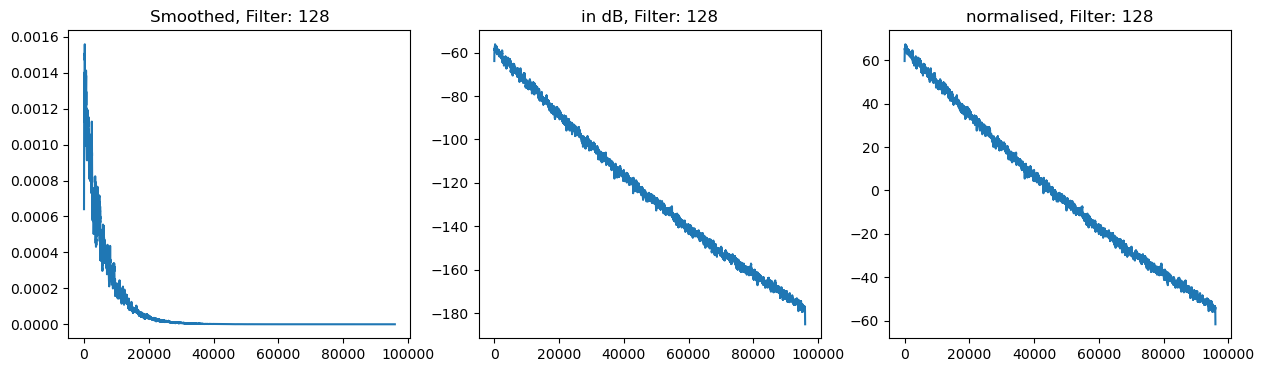

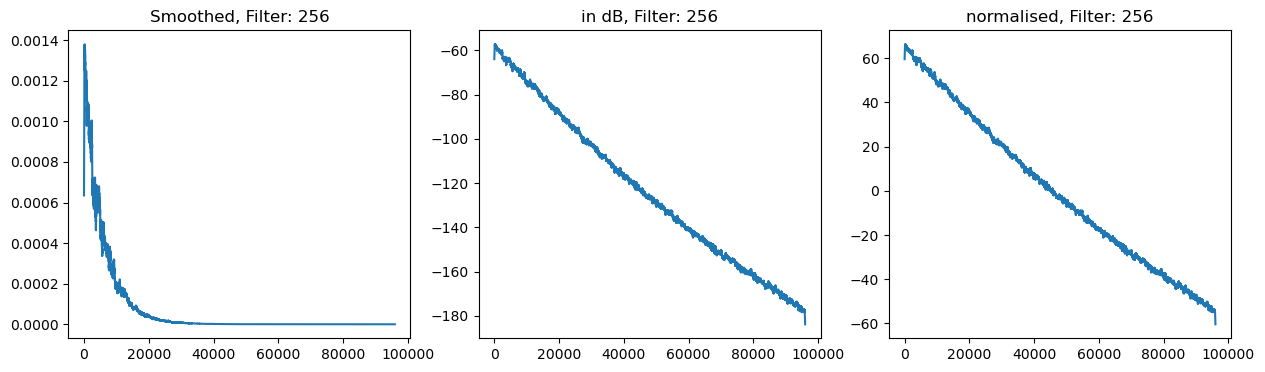

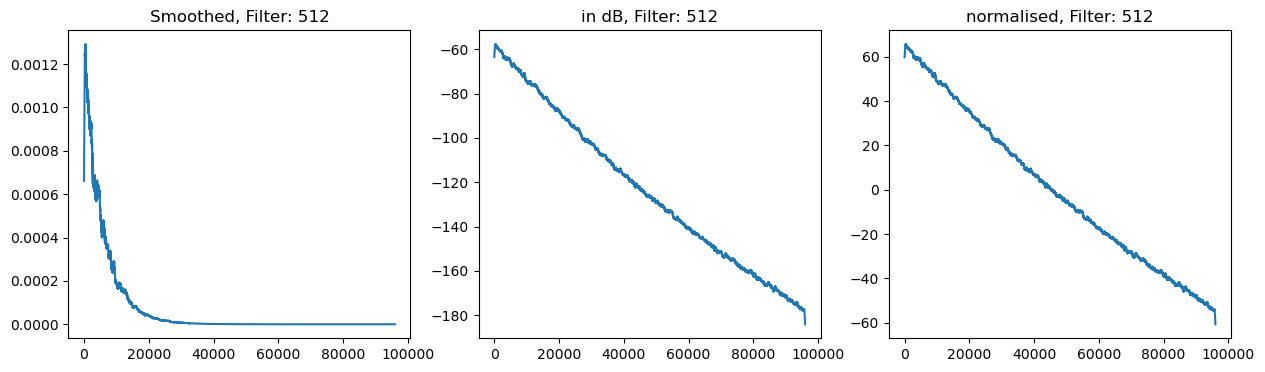

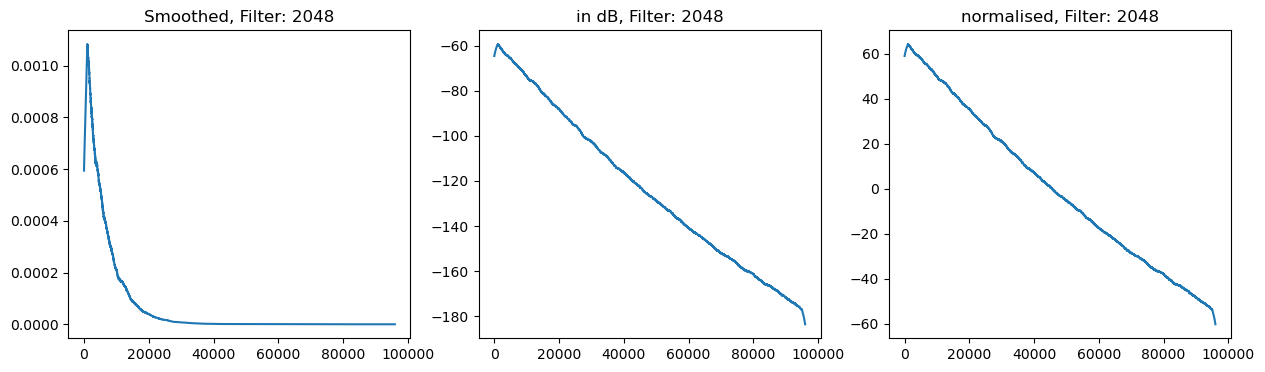

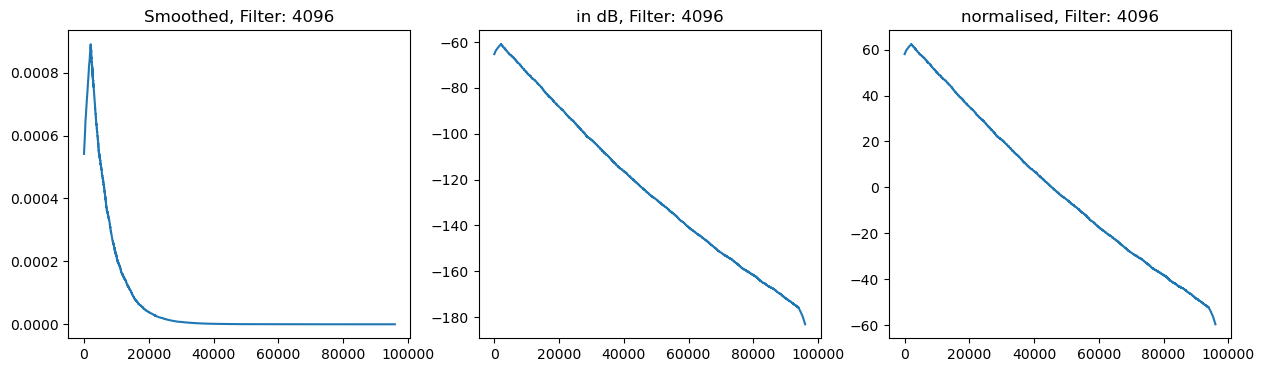

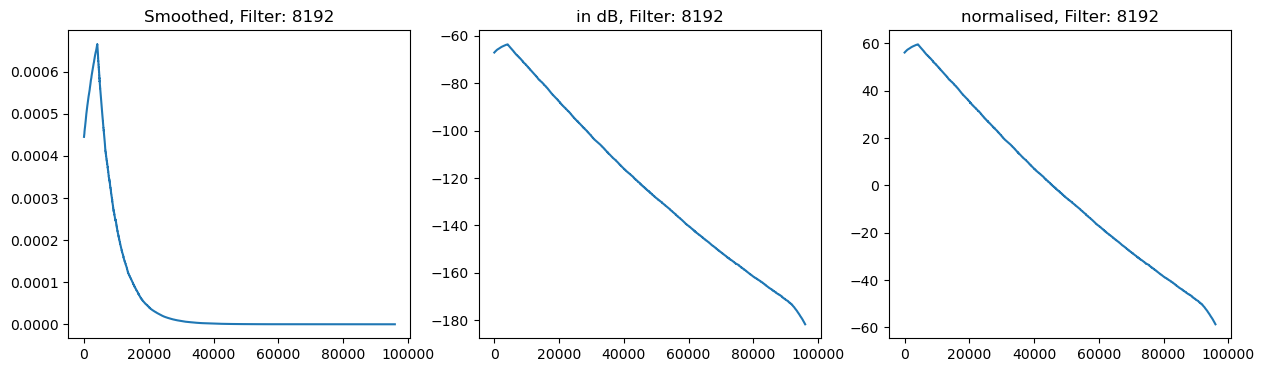

In [23]:
# Print Envelope for different filters
Kx=torch.tensor(-0.019)
Ky=torch.tensor(-0.021)
Kz=torch.tensor(-0.012)
labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)
t = np.array([1,2,4,16, 32, 64])*128
for it in t:
    env_makerF(labels, it,  gain=None, title_str=str(it), display_plots=True, normalise=True)

In [ ]:
# getBack function
def getBack(var_grad_fn):
    print(var_grad_fn)
    for n in var_grad_fn.next_functions:
        if n[0]:
            try:
                tensor = getattr(n[0], 'variable')
                print(n[0])
                print('Tensor with grad found:', tensor)
                print(' - gradient:', tensor.grad)
                print()
            except AttributeError as e:
                getBack(n[0])

In [3]:
# Frequency Dependent RIR
# training params
iter_ = 51
lr = 0.0000001
env_filter_len = 1023
signal_gain = 100    # dB
dB_clip = None

labels, target_K_values = generate_frequencyRIR(L = torch.tensor([3,4,5]))  # RIR * 6
#print("Target: ", target_K_values)
nBands = labels.size(1)
k_array = torch.zeros((nBands, 3))
#
for j in range(nBands):
    # for each frequency band
    print(f"Target Kvalues for band{j+1}: {target_K_values[j,:]}")
    l_env = env_makerF(labels[:, j], filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip)#.float().requires_grad_().cuda()
    mod = RIR_model()#.cuda()
    crit = torch.nn.MSELoss()#.cuda()
    optim = torch.optim.SGD(mod.parameters(),lr=lr)
    init_param_dict = {}
    print("Initial model Params:")
    for name, param in mod.named_parameters():
        if param.requires_grad:
            print( name,': ', param.data)
            init_param_dict.update({name:param.data.clone()})

    t_l = []
    for i in range(iter_):
        optim.zero_grad()
        y_hat = mod.forward()
        x_env = env_makerF(y_hat, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip)
        # l = crit(labels, y_hat)
        #l = crit(x_env, l_env)
        l = torch.mean(torch.abs(x_env - l_env))
        l.backward()
        optim.step()
        t_l.append(l.detach().cpu())
        if i%50 == 0 : print(f'Loss in epoch:{i} is : {l.detach()}')
    

    print(f"\nRIR no:{j+1},\nUpdated model Params:")
    final_param_collector = torch.zeros((1))
    for name, param in mod.named_parameters():
        if param.requires_grad:
            print( name,': ', param.data)
            final_param_collector = torch.concat((final_param_collector, param.data.view(-1)))
    final_param_collector = final_param_collector[1:]
    k_array[j, :] = final_param_collector

#   
    # print(param_dict)
    plt.figure(j+1, figsize=(12,4))
    plt.suptitle(f"Frequency Band {j+1}")
    plt.subplot(1,2,1)
    plt.plot(t_l,)# linestyle='', marker='.')
    plt.title("Train Loss")
    plt.subplot(1,2,2)
    plt.plot(env_makerF(generate_stochastic_rir(Kx=init_param_dict['Kx'], Ky=init_param_dict['Ky'], Kz=init_param_dict['Kz']), filter_len=1023, gain=100), label='initial')
    plt.plot(l_env,  label='target')
    plt.plot(env_makerF(mod.forward().detach(), filter_len=1023, gain=100), label='prediction')
    plt.title("RIR envelopes")
    plt.legend()
    plt.show()
    

Target Kvalues for band1: tensor([-0.0153, -0.0128, -0.0114])


NameError: name 'env_makerF' is not defined

Target params: Kx:-0.02199999988079071, Ky:-0.01600000075995922, KZ:-0.012000000104308128
Target params Deltas: del_Kx:-0.02199999988079071, del_Ky:0.0059999991208314896, del_KZ:0.0040000006556510925
Inital Params: 

del_Kx :  tensor(-0.0196)
del_Ky :  tensor(0.0021)
del_Kz :  tensor(0.0007)
Loss in epoch:0 is : 9.906380653381348
Loss in epoch:25 is : 1.285531997680664
Loss in epoch:50 is : 1.1551357507705688
Loss in epoch:75 is : 0.8564532995223999
Loss in epoch:100 is : 1.5746188163757324
Loss in epoch:125 is : 1.757153034210205
Loss in epoch:150 is : 1.3321771621704102
Loss in epoch:175 is : 5.427736759185791
Loss in epoch:200 is : 1.8673608303070068
Loss in epoch:225 is : 1.0151985883712769
Loss in epoch:250 is : 1.2471369504928589
Updated Params: 

del_Kx :  tensor(-0.0199)
del_Ky :  tensor(0.0034)
del_Kz :  tensor(0.0033)
Kx:  tensor(-0.0199)
Ky:  tensor(-0.0165)
Kz:  tensor(-0.0132)


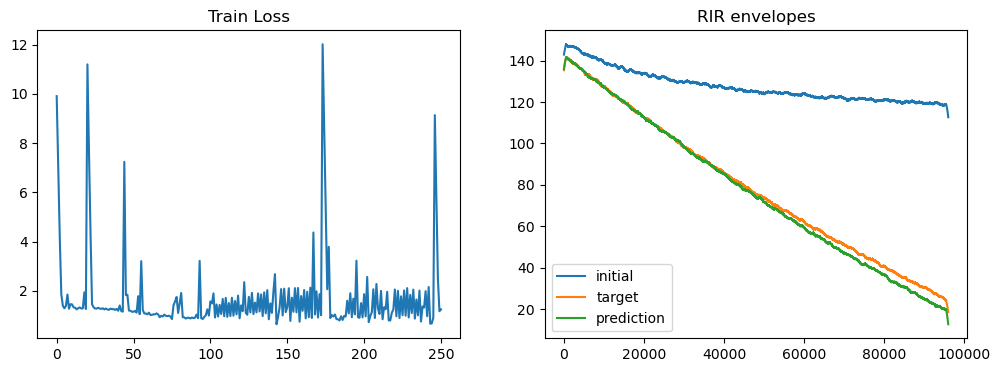

In [26]:
# delta K's model training
# training params
iter_ = 251
lr = 0.0000001
env_filter_len = 1023
signal_gain = 100    # dB
dB_clip = None
normalise = True
# K tensors
Kx=torch.tensor(-0.022) 
Ky=torch.tensor(-0.016)
Kz=torch.tensor(-0.012)
kes = torch.sort(torch.cat([Kx.view(-1), Ky.view(-1), Kz.view(-1)]))[0]
del_Kx = kes[0]
del_Ky = kes[1] - kes[0]
del_Kz = kes[2] - kes[1]
labels = generate_stochastic_rir_del(del_Kx=del_Kx, del_Ky=del_Ky, del_Kz=del_Kz)
# labels = generate_stochasticRIR(L=torch.Tensor([6,4,5]))#.cuda())#.cuda()
# labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)
#l_env = torch.Tensor(ob.envelope(labels.detach())).float().requires_grad_().cuda()
l_env = env_makerF(labels, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalise, )#.float().requires_grad_().cuda()
#
mod = RIR_model2()#.cuda()
crit = torch.nn.MSELoss()#.cuda()
optim = torch.optim.SGD(mod.parameters(),lr=lr)
print(f"Target params: Kx:{np.round(Kx.numpy(), 4)}, Ky:{Ky}, KZ:{Kz}")
print(f"Target params Deltas: del_Kx:{del_Kx}, del_Ky:{del_Ky}, del_KZ:{del_Kz}")
print("Inital Params: \n")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
# plt.figure(1)
# plt.plot(labels)
# #plt.show()
# y_env = env_maker0(labels)
# plt.figure(2)
# plt.plot(y_env)
# plt.show()


t_l = []
for i in range(iter_):
    optim.zero_grad()
    y_hat = mod.forward()
    x_env = env_makerF(y_hat, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalise)
    # l = crit(labels, y_hat)
    #l = crit(x_env, l_env)
    l = torch.mean(torch.abs(x_env - l_env))
    l.backward()
    optim.step()
    t_l.append(l.detach().cpu())
    if i%25 == 0 : print(f'Loss in epoch:{i} is : {l.detach()}')

final_param_dict = {}
print("Updated Params: \n")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
        final_param_dict.update({name: param.data.clone()})
# print params
print("Kx: ", final_param_dict['del_Kx'])
print("Ky: ", final_param_dict['del_Ky'] + final_param_dict['del_Kx'])
print("Kz: ", final_param_dict['del_Kz'] + final_param_dict['del_Ky']+ final_param_dict['del_Kx'])
#
plt.figure(1, figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t_l,)# linestyle='', marker='.')
plt.title("Train Loss")
plt.subplot(1,2,2)
plt.plot(env_makerF(generate_stochastic_rir(Kx=final_param_dict['del_Kx'], Ky=final_param_dict['del_Ky'], Kz=final_param_dict['del_Kz']), filter_len=1023, gain=100), label='initial')
plt.plot(l_env,  label='target')
plt.plot(env_makerF(mod.forward().detach(), filter_len=1023, gain=100), label='prediction')
plt.title("RIR envelopes")
plt.legend()
plt.show()

tensor(666.6969)


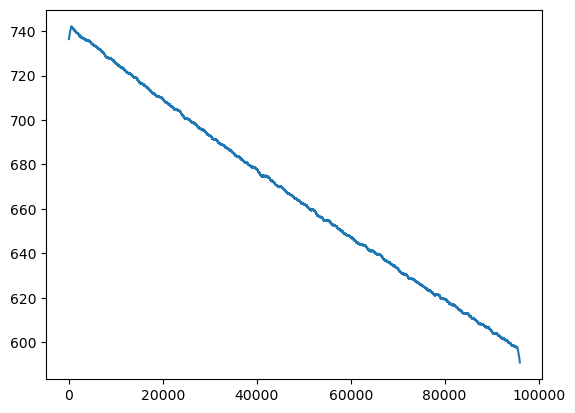

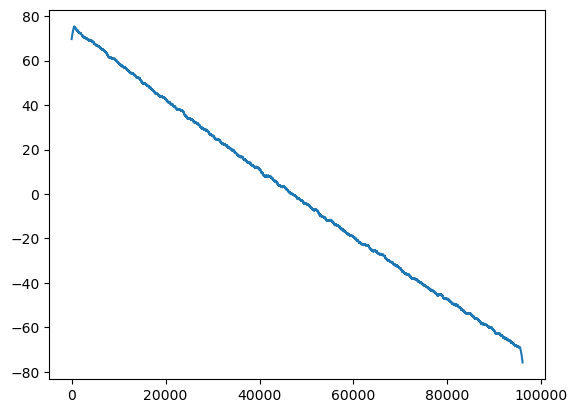

In [12]:
# normalise around zero
labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)
l_env = env_makerF(labels, filter_len=1023  , gain=400, clip_=None)
print(torch.mean(l_env))
plt.figure(1)
plt.plot(l_env)
# normalize before l2 loss
plt.figure(2)
plt.plot(l_env - torch.mean(l_env))

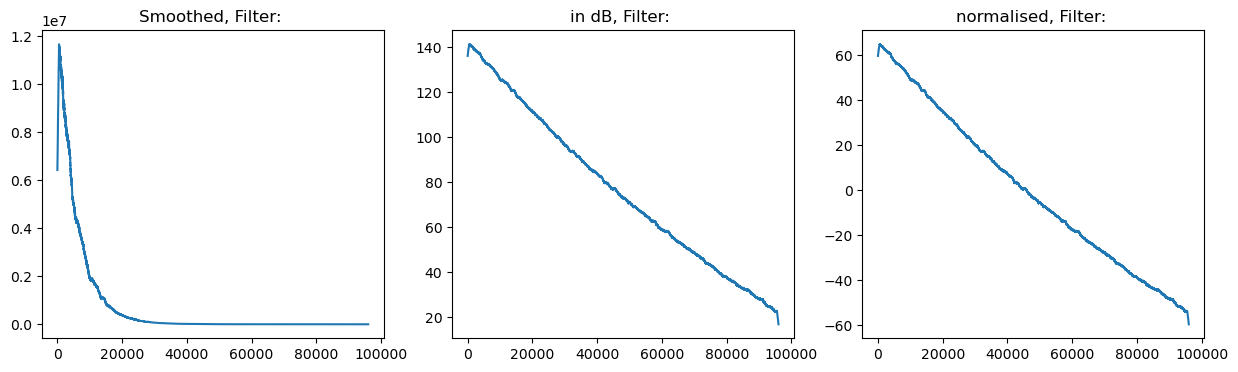

Target params: Kx:-0.01899999938905239, Ky:-0.020999999716877937, KZ:-0.012000000104308128
Inital Params: 

Kx :  tensor([-0.0132])
Ky :  tensor([-0.0144])
Kz :  tensor([-0.0194])
Loss in epoch:0 is : 1.0172330141067505
Loss in epoch:25 is : 0.8791463971138
Loss in epoch:50 is : 0.7720797657966614
Loss in epoch:75 is : 0.8074301481246948
Loss in epoch:100 is : 0.6799585223197937
Loss in epoch:125 is : 0.5511189103126526
Loss in epoch:150 is : 0.5439620614051819
Loss in epoch:175 is : 0.5466563105583191
Loss in epoch:200 is : 0.5130627155303955
Loss in epoch:225 is : 0.47093212604522705
Loss in epoch:250 is : 0.4763416647911072
Loss in epoch:275 is : 0.5168004631996155
Updated Params: 

Kx :  tensor([-0.0123])
Ky :  tensor([-0.0176])
Kz :  tensor([-0.0223])


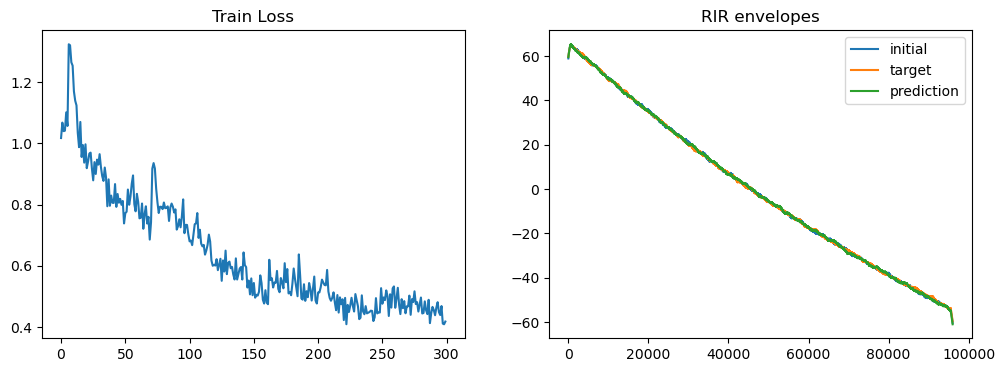

In [25]:
# K's model training
# training params
iter_ = 300
lr = 0.0000001
env_filter_len = 1023
signal_gain = 100    # dB
dB_clip = None
normalise = True
# K tensors
Kx=torch.tensor(-0.019)
Ky=torch.tensor(-0.021)
Kz=torch.tensor(-0.012)
# labels = generate_stochasticRIR(L=torch.Tensor([6,4,5]))#.cuda())#.cuda()
labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)
#l_env = torch.Tensor(ob.envelope(labels.detach())).float().requires_grad_().cuda()
l_env = env_makerF(labels, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalise, display_plots=True)#.float().requires_grad_().cuda()
#
mod = RIR_model()#.cuda()
crit = torch.nn.MSELoss()#.cuda()
optim = torch.optim.SGD(mod.parameters(),lr=lr)
print(f"Target params: Kx:{np.round(Kx.numpy(), 4)}, Ky:{Ky}, KZ:{Kz}")
print("Inital Params: \n")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
# plt.figure(1)
# plt.plot(labels)
# #plt.show()
# y_env = env_maker0(labels)
# plt.figure(2)
# plt.plot(y_env)
# plt.show()


t_l = []
for i in range(iter_):
    optim.zero_grad()
    y_hat = mod.forward()
    x_env = env_makerF(y_hat, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalise)
    # l = crit(labels, y_hat)
    #l = crit(x_env, l_env)
    l = torch.mean(torch.abs(x_env - l_env))
    l.backward()
    optim.step()
    t_l.append(l.detach().cpu())
    if i%25 == 0 : print(f'Loss in epoch:{i} is : {l.detach()}')

final_param_dict = {}
print("Updated Params: \n")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
        final_param_dict.update({name: param.data.clone()})

#
plt.figure(1, figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t_l,)# linestyle='', marker='.')
plt.title("Train Loss")
plt.subplot(1,2,2)
plt.plot(env_makerF(generate_stochastic_rir(Kx=final_param_dict['Kx'], Ky=final_param_dict['Ky'], Kz=final_param_dict['Kz']), filter_len=env_filter_len, gain=signal_gain, normalise=normalise), label='initial')
plt.plot(l_env,  label='target')
plt.plot(env_makerF(mod.forward().detach(), filter_len=env_filter_len, gain=signal_gain, normalise=normalise), label='prediction')
plt.title("RIR envelopes")
plt.legend()
plt.show()
# plt.figure(1)
# plt.plot(t_l,)# linestyle='', marker='.')
# plt.show()

In [ ]:
# check anomaly 
torch.autograd.set_detect_anomaly(True) 

mod = RIR_model()
# hndd = mod.register_full_backward_hook(backward_hook)
labels = generate_stochastic_rir(Kx=torch.tensor(-0.012),Ky=torch.tensor( -0.016),Kz=torch.tensor( -0.018))
optim = torch.optim.Adam(mod.parameters(), lr=0.001)
# for i in range(3):
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
optim.zero_grad()
y = mod.forward()
# y.register_hook(lambda t: print(f'hook0 : {t}'))
l = torch.abs((labels - y)).sum()
# P = l.register_hook(lambda t: print(f'hook1 : {t}'))
print("lossValue: ", l)
l.retain_grad()
l.backward()

#print('Tracing back tensors:')
optim.step()

# hndd.remove()
# make_dot(y, params=dict(mod.named_parameters()))


In [ ]:
# Print model graph
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1, 8)
with torch.autograd.graph.saved_tensors_hooks(pack_hook, unpack_hook):
    y = model(x)


make_dot(y.mean(), params=dict(model.named_parameters()))

## Part for SGD basics

### A. Gradient descent for finding the minima of a function
1. We have a function $y=f(x)=x²$, and we want to find the minima of that function.<br>
2. we take a starting guess $x_0$ in the available range. <br>
3. Then we evaluate $\frac{d}{dx}f(x)|_{x=x_0}$ and update $x_0 = x_0 - \alpha\frac{d}{dx}f(x)|_{x=x_0}$,<br>
where $\alpha$ is the learning rate
4. We continue reiterating untill $\frac{d}{dx}f(x)\approxeq0$
   
N.B : 
1. The function f has to continously differentiable to apply GD
2. The function needs to be concave/convex to find global minima

### B. Gradient descent for finding inverse of a funciton / <br> Model the inverse of any unknown function

1. We have $y=f(x)$ where f can be any function
2. We want to find $g(y)=f^{-1}(y)$ , such that for any y, we can find<br>
    corresponding $\hat{x}=g(y)$
3. For this we take a NN model and optimize it using GD to achieve $\hat{x}\approxeq x$
4. Then the trained NN model is $\approxeq f^{-1}$  

In [ ]:
Kx=torch.tensor(-0.019)
Ky=torch.tensor( -0.018)
Kz=torch.tensor( -0.018)
# labels = generate_stochasticRIR(L=torch.Tensor([6,4,5]))#.cuda())#.cuda()
labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)
#l_env = torch.Tensor(ob.envelope(labels.detach())).float().requires_grad_().cuda()
#l_env = env_maker(labels).float().requires_grad_().cuda()
#
mod = RIR_model()#.cuda()
crit = torch.nn.MSELoss()#.cuda()
optim = torch.optim.SGD(mod.parameters(),lr=0.001)
print(f"Target params: Kx:{Kx}, Ky:{Ky}, KZ:{Kz}")
print("Inital Params: \n")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
# plt.figure(1)
# plt.plot(labels)
# #plt.show()
# y_env = env_maker0(labels)
# plt.figure(2)
# plt.plot(y_env)
#plt.show()
# def pack_hook(x):
#     print("Packing", x.size(), x.grad_fn)
#     return x

# def unpack_hook(x):
#     if torch.any(torch.isnan(x)):
#         print("Unpacking Nan: ", x.size(), x.grad_fn)
#     else:
#         print("Unpacking: ", x.size(), x.grad_fn)
#     return x

t_l = []
for i in range(500):
    # print(f'#######\n ##Epoch:{i} \n #######')
    # with torch.autograd.graph.saved_tensors_hooks(pack_hook, unpack_hook):
    optim.zero_grad()
    y_hat = mod.forward()
    # x_env = env_maker0(y_hat)
    # y_env = env_maker0(labels)
    # l = torch.mean(torch.abs(y_hat - labels))
    l = crit(labels, y_hat)
    #yy = y_hat.detach().cpu()
    #env_y = ob.envelope(yy).float().requires_grad_().cuda()
    #env_y = env_maker(yy).float().requires_grad_().cuda()
    # l = crit(x_env, y_env)
    l.backward()
    # print('Tracing back tensors:')
    # getBack(l.grad_fn)
    # mod.float()
    optim.step()
    t_l.append(l.detach().cpu())
    print(f'Loss in epoch:{i} is : {l.detach()}')


print("Updated Params: \n")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)

#
# plt.figure(2)
# plt.plot(t_l)
plt.show()

In [ ]:
# Dummy Model train
torch.autograd.set_detect_anomaly(True) 
def gen_mul(a, x):
    return a*x
def gen_add(b, x):
    return x + b

class func_NN(torch.nn.Module):
    def __init__(self,) :
        super().__init__()
        self.a = torch.nn.Parameter(torch.rand(1))
        self.b = torch.nn.Parameter(torch.rand(1))
        #self.x = torch.nn.Parameter(torch.linspace(-1, 1, 100))
        # self.x = torch.linspace(-1, 1, 10)

    def forward(self, inp):
        # mul_x = torch.cos(self.a.view(-1,1)*inp)
        mul_x = gen_mul(self.a.view(-1,1), inp)
        # sum_x = mul_x - self.b
        sum_x = gen_add(self.b, mul_x)
        if sum_x.requires_grad : sum_x.register_hook(lambda x : print("sumx", x, sum_x.grad_fn))
        #return mul_x
        return sum_x
        # return mul_x + b
        #return generate_stochasticRIR(L=(), K=())
def pack_hook(x):
    # print("Packing", x)
    return x

def unpack_hook(x):
    # print("Unpacking", x)
    return x

# label
a = torch.Tensor([0.5])
b = torch.Tensor([0.8])
x = torch.linspace(-1, 1, 10)
y = gen_add(b, gen_mul(a,x)) + (0.1**0.5)*torch.randn_like(x)*(0.1)
# y = torch.cos(a*x) + (0.1**0.5)*torch.randn_like(x)*(0.001) + b
inp = x
foo = func_NN()
# hnd = foo.register_full_backward_hook(backward_hook)
print("inint model")
for name, param in foo.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(foo.parameters(),lr=0.001)

t_l = []
for i in range(2):
    # print(f'#######\n ##Epoch:{i} \n #######')
    # for name, param in foo.named_parameters():
    #     if param.requires_grad:
    #         print( name,': ', param.data)
    # with torch.autograd.graph.saved_tensors_hooks(pack_hook, unpack_hook):
    optim.zero_grad()
    l = loss(y, foo.forward(inp=inp))
    # l.retain_grad()
    # l.register_hook(print)
    # print('L:',l)
    
    l.backward()
    # print('Tracing back tensors:')
    # getBack(l.grad_fn)
    optim.step()
    t_l.append(l.detach())
# hnd.remove()

print("Final Loss: ", loss(y, foo.forward(inp)).detach())
print('Parameters: \n', 'Original: a:', a, ' b: ',b, '\n Predicted: ')

for name, param in foo.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.xlabel("Epochs Trained")
plt.ylabel("Train Loss")
plt.plot(t_l)
plt.yscale('log')
#print(func_NN.parameters())
plt.subplot(1,2,2)
plt.plot(x, y.squeeze(), linestyle='', marker='v', label='labels')
plt.plot(x, foo.forward(inp=inp).detach().squeeze(), linestyle='', marker='.', label='preds')
plt.xlabel("Value of Y")
plt.ylabel("Value of X")
plt.legend()


In [ ]:
y = foo(inp)
make_dot(y, params=dict(foo.named_parameters()))

In [ ]:
## A part

# define function and df
def f(x):
   return x**2 - 4*x + 6

def df(x):
   return 2*x - 4


# params
initial_x = 4
learning_rate = 0.1
num_iterations = 50
history_x = [initial_x]

# finding minima
x = initial_x
for i in range(num_iterations):
   gradient = df(x)
   x = x - learning_rate * gradient
   history_x.append(x)

# plot
x_vals = np.linspace(-1, 5, 100)
plt.plot(x_vals, f(x_vals))
plt.plot(history_x, f(np.array(history_x)), 'rx')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gradient Descent')
plt.show()

In [ ]:
## B part

# Creating a function f(X) with a slope of -5
X = torch.arange(-5, 5, 0.1).view(-1, 1)
func =  -2*X**2 + 5

# Adding Gaussian noise to the function f(X) and saving it in Y
Y = func + 0.9 * torch.randn(X.size())


# defining the function for forward pass for prediction
def forward(x):
    return w * x + b

# evaluating data points with Mean Square Error (MSE)
def criterion(y_pred, y):
    return torch.mean((y_pred - y) ** 2)

# Batch gradient descent
w = torch.tensor(-10.0, requires_grad=True)
b = torch.tensor(-20.0, requires_grad=True)
step_size = 0.1
loss_BGD = []
n_iter = 50

for i in range (n_iter):
    # making predictions with forward pass
    Y_pred = forward(X)
    # calculating the loss between original and predicted data points
    loss = criterion(Y_pred, Y)
    # storing the calculated loss in a list
    loss_BGD.append(loss.item())
    # backward pass for computing the gradients of the loss w.r.t to learnable parameters
    loss.backward()
    # updateing the parameters after each iteration
    w.data = w.data - step_size * w.grad.data
    b.data = b.data - step_size * b.grad.data
    # zeroing gradients after each iteration
    w.grad.data.zero_()
    b.grad.data.zero_()
    # priting the values for understanding
    print('{}, \t{}, \t{}, \t{}'.format(i, loss.item(), w.item(), b.item()))

# # Stochastic gradient descent
# w = torch.tensor(-10.0, requires_grad=True)
# b = torch.tensor(-20.0, requires_grad=True)
# step_size = 0.1
# loss_SGD = []
# n_iter = 20

# for i in range(n_iter):  
#     # calculating true loss and storing it
#     Y_pred = forward(X)
#     # store the loss in the list
#     loss_SGD.append(criterion(Y_pred, Y).tolist())

#     for x, y in zip(X, Y):
#       # making a pridiction in forward pass
#       y_hat = forward(x)
#       # calculating the loss between original and predicted data points
#       loss = criterion(y_hat, y)
#       # backward pass for computing the gradients of the loss w.r.t to learnable parameters
#       loss.backward()
#       # updateing the parameters after each iteration
#       w.data = w.data - step_size * w.grad.data
#       b.data = b.data - step_size * b.grad.data
#       # zeroing gradients after each iteration
#       w.grad.data.zero_()
#       b.grad.data.zero_()
#       # priting the values for understanding
#       print('{}, \t{}, \t{}, \t{}'.format(i, loss.item(), w.item(), b.item()))

X = X.detach()
w = w.detach().item()
b = b.detach().item()
print(w, b)
# Plot and visualizing the data points in blue
plt.plot(X.numpy(), Y.numpy(), 'b+', label='Y')
plt.plot(X.numpy(), func.numpy(), 'r', label='func')
plt.plot(X, (w*X)+b, label='preds')
#plt.plot(*X.numpy()+b.detach().numpy(), label="prediction")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid('True', color='y')
plt.show()


# Plot graphs
plt.plot(loss_BGD, label="Batch Gradient Descent")
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.legend()
plt.show()

# plt.plot(loss_SGD,label="Stochastic Gradient Descent")
# plt.xlabel('Epoch')
# plt.ylabel('Cost/Total loss')
# plt.legend()
# plt.show()